In [1]:
import jax
jax.config.update("jax_enable_x64", True)

# Simulating trajectories

## Circular eddies configuration

In this example we will consider an idealised configuration (inspired by [this one](https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html#Running-particles-in-an-idealised-field) from Parcels documentation) where the velocity field presents two eddies displaced over time.

We consider a spatial domain spanning from 29° to 31° latitude and -1° to 1° longitude, and a time period of two days.

In [2]:
import jax.numpy as jnp

In [3]:
ny = nx = 101
nt = 49

lat = jnp.linspace(29, 31, ny)
lon = jnp.linspace(-1, 1, nx)

dt = jnp.asarray(1*60*60)  # 1 hour in seconds
ts = jnp.linspace(0, dt * (nt - 1), nt)

Below we defined our fields, considering circular and geostrophic eddies.

In [4]:
from sealagrangiax.utils.unit import degrees_to_meters

In [5]:
dy, dx = degrees_to_meters(jnp.asarray([lat[1] - lat[0], lon[1] - lon[0]]), lat.mean())

# SSH field parameters
eta0 = .4
sig = 0.1
eta_fn = lambda _dx, _dy: eta0 * jnp.exp(-(_dx / (sig * nx))**2 - (_dy / (sig * ny))**2)
xi, yi = jnp.meshgrid(jnp.arange(lon.size), jnp.arange(lat.size), indexing="ij")

# eddies displacement parameters
eddy_speed = .05
dxi = eddy_speed * dt / dx
dyi = eddy_speed * dt / dy

# SSH field
eta = jnp.zeros((nt, ny, nx))
for t in range(nt):
    # eddy 1
    x1 = 0.5 * lon.size - (8 + dxi * t)
    y1 = 0.5 * lat.size - (8 + dyi * t)
    eta = eta.at[t, :, :].add(eta_fn((x1 - xi), (y1 - yi)))

    # eddy 2
    x2 = 0.5 * lon.size + (8 + dxi * t)
    y2 = 0.5 * lat.size + (8 + dyi * t)
    eta = eta.at[t, :, :].add(-eta_fn((x2 - xi), (y2 - yi)))

# geostrophic velocities
coriolis_factor = 2 * 7.292115e-5 * jnp.sin(jnp.radians(lat.mean()))
g = 9.81

u = jnp.zeros_like(eta)
u = u.at[:, :-1, :].set(jnp.diff(eta[:, :, :], axis=1) / dy / coriolis_factor * g)
u = u.at[:, -1, :].set(u[:, -2, :])

v = jnp.zeros_like(eta)
v = v.at[:, :, :-1].set(-jnp.diff(eta[:, :, :], axis=-1) / dx / coriolis_factor * g)
v = v.at[:, :, -1].set(v[:, :, -2])

In [6]:
import matplotlib.pyplot as plt

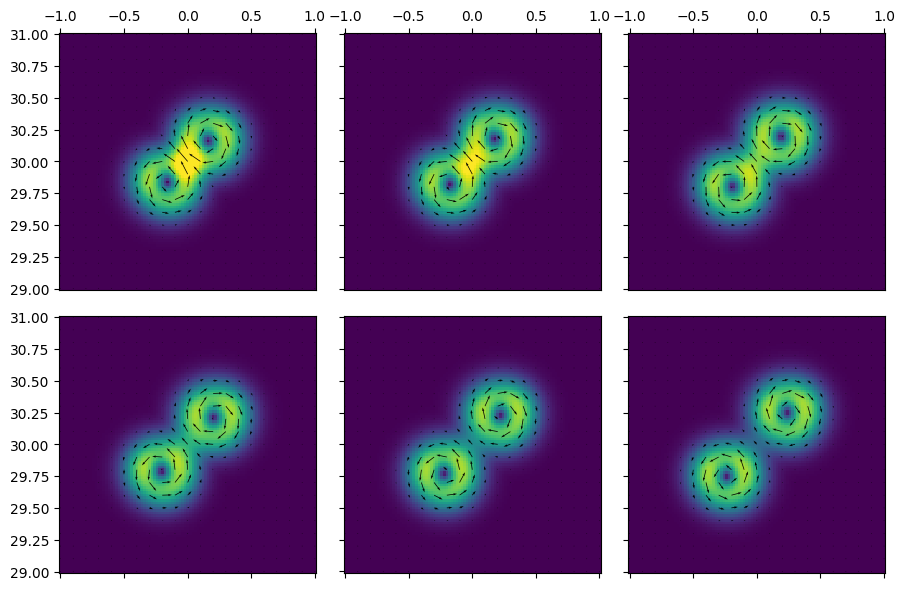

In [7]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9, 6))
axes = axes.flatten()

for ax_i, uv_i in zip(range(axes.size), jnp.linspace(0, nt - 1, axes.size).astype(int)):
    ax = axes[ax_i]
    
    im = ax.pcolormesh(
        lon, lat,
        jnp.sqrt(u[uv_i]**2 + v[uv_i]**2), 
        vmax=2.75, vmin=0,
        cmap="viridis"
    )
    ax.quiver(
        lon[::5], lat[::5], 
        u[uv_i][::5, ::5], v[uv_i][::5, ::5],
        scale=50
    )

    ax.set_aspect("equal")

    if ax_i < 3:
        ax.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
    else:
        ax.tick_params(bottom=True, labelbottom=False, top=False, labeltop=False)

fig.tight_layout()

## Deterministic simulation

Let's start with the simpliest use-case: advecting a single particle inside our given velocity field.

In order to interpolate this velocity field during the simulation of the trajectory we define a `sealagrangiax.Dataset` (a `xarray.Dataset`-likish object compatible with JAX just-in-time compilation mechanism).

In [8]:
from sealagrangiax.grid import Dataset

In [9]:
two_eddies_ds = Dataset.from_arrays(
    variables={"u": u, "v": v},  # the fields
    time=ts, latitude=lat, longitude=lon,  # the coordinates
)

The initial position of our particle is [30, 0] (° latitude/longitude).
We use `sealagrangiax.Location` structure to represent positions.

In [10]:
from sealagrangiax.trajectory import Location

In [11]:
x0 = Location([30, 0])

Finally, we will advect this particle using the `sealagrangiax.IdentitySSC` simulator.

In [12]:
from sealagrangiax.simulator import IdentitySSC

In [13]:
dt0 = jnp.asarray(15*60)  # integration timestep: 15 minutes in seconds

In [14]:
ssc_sim = IdentitySSC()
traj = ssc_sim(two_eddies_ds, x0, ts[1:-1], dt0=dt0)

The simulator outputs a `sealagrangiax.Trajectory` object.
We can plot it using its method `plot`.

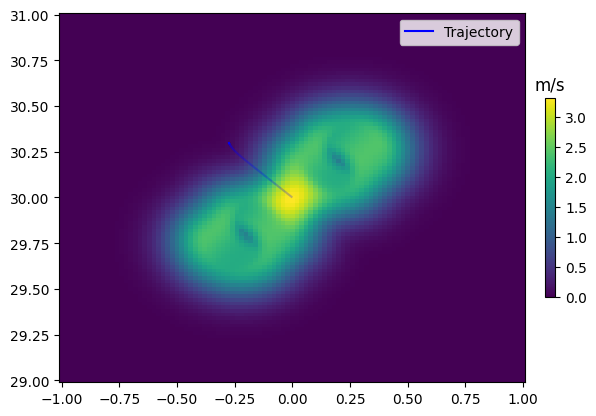

In [15]:
# plot the field
fig, ax = plt.subplots()

im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)

clb.ax.set_title("m/s")

# add the trajectory
ax = traj.plot(ax, label="Trajectory", color="blue")
ax.legend()

plt.show()

The result is a bit disappointing: as the particle is released right "between" the eddies it drifts straight "outside", which might not seem very realistic (this situation is artificially created on purpose of course).

To remedy this we can try to generate a stochastic ensemble of trajectories.

## Stochastic simulation

In this example, we generate an ensemble of 100 trajectories by sampling solutions from a Stochastic Differential Equation with Smagorinsky diffusion using the `sealagrangiax.SmagorinskyDiffusion` simulator.

In [16]:
from sealagrangiax.simulator import SmagorinskyDiffusion

In [17]:
n_samples = jnp.asarray(100)

In [18]:
smag_sim = SmagorinskyDiffusion.from_param(cs=1e-1)
traj_ens = smag_sim(two_eddies_ds, x0, ts[1:-1], dt0=dt0, n_samples=n_samples)

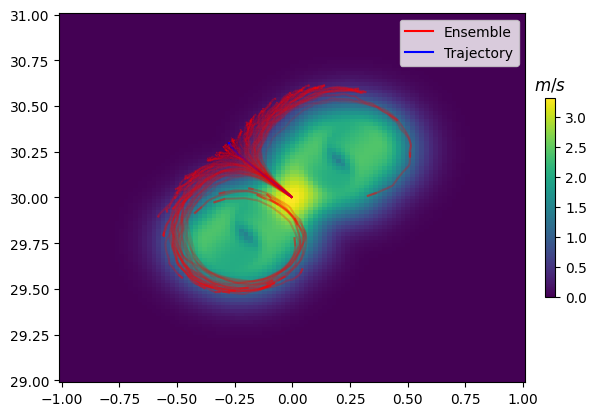

In [19]:
# plot the field
fig, ax = plt.subplots()

im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)

clb.ax.set_title("$m/s$")

# add the ensemble
ax = traj_ens.plot(ax, label="Ensemble", color="red")

# add the trajectory on top
ax = traj.plot(ax, label="Trajectory", color="blue")
ax.legend()

plt.show()

And we see that the ensemble is affected by the presence of the two eddies.

# Learning simulators parametrization

Using `JAX` we have the ability to write fully differentiable simulators and to learn their parametrization (even for a large number of parameters).

To demonstrate how we can do this, we will focus on the very simple scenario of a constant (in space and time) velocity field $\mathbf{u}$ and two deterministic simulators that utilize only only $\mathbf{u}$.

One simulator knows the velocity field, and we will use its simulated trajectory as reference to fit the parameters of the other one.
The second simulator uses as input a modified version of the field: $\widehat{\mathbf{u}} = (\mathbf{u} - b) / a$, and is able itself to apply the linear transformation $x \mapsto \beta_0 + x \beta_1$ to $\widehat{\mathbf{u}}$.
Therefore, it should be possible to estimate the expected values of $\beta_0$ and $\beta_1$ (which correspond to $b$ and $a$, respectively).

In [20]:
true_cst_u = jnp.full((nt, ny, nx), 0.5)
true_cst_v = jnp.full((nt, ny, nx), 0.25)

true_cst_ds = Dataset.from_arrays(
    variables={"u": true_cst_u, "v": true_cst_v},
    time=ts, latitude=lat, longitude=lon,
)

In [21]:
a = 2
b = 0.1

trans_cst_u = (true_cst_u - b) / a
trans_cst_v = (true_cst_v - b) / a

trans_cst_ds = Dataset.from_arrays(
    variables={"u": trans_cst_u, "v": trans_cst_v},
    time=ts, latitude=lat, longitude=lon
)

We use a `sealagrangiax.IdentitySSC` as the simulator using the true velocity field, and a `sealagrangiax.LinearSSC`, whose `intercept` and `slope` parameters can be optimized, as the simulator using the modified velocity field.

In [22]:
import jax.random as jrd

from sealagrangiax.simulator import LinearSSC   

In [23]:
true_sim = IdentitySSC()

keys = jrd.split(jrd.key(0), 2)
intercept = jrd.uniform(keys[0], 1, dtype=float, minval=-1, maxval=1)
slope = jrd.uniform(keys[1], 1, dtype=float, minval=-1, maxval=1)
trans_sim = LinearSSC.from_param(intercept=intercept, slope=slope)

print(f"Initial parameters: (intercept={intercept.item()}, slope={slope.item()})")

Initial parameters: (intercept=-0.03947928024531988, slope=0.15310165206863147)


Let's see how their simulated trajectories compare:

In [24]:
true_traj = true_sim(true_cst_ds, x0, ts[1:-1], dt0)
est_traj = trans_sim(trans_cst_ds, x0, ts[1:-1], dt0)

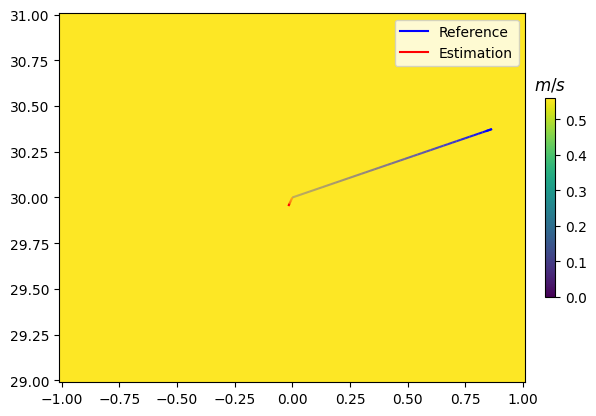

In [25]:
# plot the field
fig, ax = plt.subplots()

im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((true_cst_u[0]**2 + true_cst_v[0]**2)), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)

clb.ax.set_title("$m/s$")

# add the reference
ax = true_traj.plot(ax, label="Reference", color="blue")

# add the estimation
ax = est_traj.plot(ax, label="Estimation", color="red")
ax.legend()

plt.show()

As expected, the estimate is clearly quite inaccurate...

To improve this estimation by adjusting the parameters $\beta_0$ and $\beta_1$ using automatic differentiation, we essentially need to define an objective function (or loss) to minimize, and a minimizer.

There is plenty of options for the choice objective function, including:

- the Liu Index,
- the Separation distance (distance on Earth in meters),
- the Euclidean distance (distance in degrees),
- ...

that we can evaluate either at the final position of the particle or along its full trajectory.

In this case, we use the sum of the separation distances calculated every hour between the reference and the estimated trajectory, that we square to ease minimization.

In [26]:
import equinox as eqx

In [27]:
@eqx.filter_value_and_grad
def objective_fn(_sim):
    _traj = _sim(trans_cst_ds, x0, ts[1:-1], dt0)
    return (true_traj.mae(_traj).value[-1])**2 / 2

In [28]:
@eqx.filter_value_and_grad
def objective_fn(_sim):
    _traj = _sim(trans_cst_ds, x0, ts[1:-1], dt0)
    return (true_traj.rmse(_traj).value[-1])**2 / 2

In [29]:
@eqx.filter_value_and_grad
def objective_fn(_sim):
    _traj = _sim(trans_cst_ds, x0, ts[1:-1], dt0)
    return (true_traj.separation_distance(_traj).value[-1])**2 / 2

In [30]:
@eqx.filter_value_and_grad
def objective_fn(_sim):
    _traj = _sim(trans_cst_ds, x0, ts[1:-1], dt0)
    return (true_traj.liu_index(_traj).value[-1])**2 / 2

In [31]:
@eqx.filter_value_and_grad
def objective_fn(_sim):
    _traj = _sim(trans_cst_ds, x0, ts[1:-1], dt0)
    return (true_traj.euclidean_distance(_traj).value[-1])**2 / 2

In [32]:
@eqx.filter_value_and_grad
def objective_fn(_sim):
    _traj = _sim(trans_cst_ds, x0, ts[1:-1], dt0)
    return (true_traj.euclidean_distance(_traj).sum()**2 / 2).value

We can check verify it is possible to evaluate the loss and its gradients.

In [33]:
loss, grads = objective_fn(trans_sim)

print(
    f"Initial loss: {loss} and "
    f"gradients: (intercept={grads.rhs.intercept.item()}, slope={grads.rhs.slope.item()})"
)

Initial loss: 259.2976618652764 and gradients: (intercept=-1172.4252167008515, slope=-191.9264376045031)


Thanks to `optax` we have access to a large variety of optimizers.
In this example we will use the classical Adam optimizer.

In [34]:
import optax

In [35]:
learning_rate = 1e-1

In [36]:
optim = optax.adam(learning_rate)
opt_state = optim.init(trans_sim)

Using `optax`, it is also straightforward to apply gradient-based updates to the simulator parameters.

In [37]:
@eqx.filter_jit
def make_step(_sim, _opt_state):
    _loss, grads = objective_fn(_sim)
    updates, _opt_state = optim.update(grads, _opt_state)
    _sim = eqx.apply_updates(_sim, updates)
    return _loss, _sim, _opt_state

Finally, we perform the optimization over 200 update steps:

In [38]:
n_steps = 200
print_every = 20

In [39]:
for step in range(n_steps):
    loss, trans_sim, opt_state = make_step(trans_sim, opt_state)
    if (step % print_every) == 0 or step == n_steps - 1:
        print(f"Step: {step}, Loss: {loss.item()}")

Step: 0, Loss: 259.2976618652764
Step: 20, Loss: 24.017840962552373
Step: 40, Loss: 6.190829084981727
Step: 60, Loss: 1.7930803102977988
Step: 80, Loss: 0.42655486026113854
Step: 100, Loss: 0.08808017716898713
Step: 120, Loss: 0.010986454476463165
Step: 140, Loss: 0.0007682532405133117
Step: 160, Loss: 1.3627651436636214e-05
Step: 180, Loss: 6.699587574700361e-06
Step: 199, Loss: 2.444729937215066e-06


Considering the final loss, we should now expect very good agreement between the two trajectories.

In [40]:
est_traj = trans_sim(trans_cst_ds, x0, ts[1:-1], dt0)

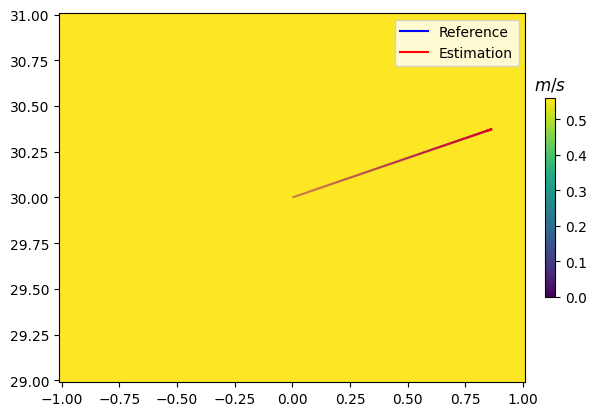

In [41]:
# plot the field
fig, ax = plt.subplots()

im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((true_cst_u[0]**2 + true_cst_v[0]**2)), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)

clb.ax.set_title("$m/s$")

# add the reference
ax = true_traj.plot(ax, label="Reference", color="blue")

# add the estimation
ax = est_traj.plot(ax, label="Estimation", color="red")
ax.legend()

plt.show()

And indeed, in this toy use-case, we were able to perfectly simulate the reference trajectory.

We can also see that we have learned the expected parametrization of our simulator:

In [42]:
print(f"Final parameters: (intercept={trans_sim.rhs.intercept.item()}, slope={trans_sim.rhs.slope.item()})")

Final parameters: (intercept=0.09991617278188675, slope=2.0006293324761972)
